# M3 resolVI training

## Purpose
Manually annotate cell types in the M3 MERFISH dataset then train resolVI for automated cell type annotation and doublet detection.

## Setup

In [ ]:
from pathlib import Path

import anndata as ad
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import petracer
import scanpy as sc
import scipy as sp
import scvi
import seaborn as sns

np.random.seed(42)

base_path, data_path, plots_path, results_path = petracer.config.get_paths("tumor_tracing")
petracer.config.set_theme()

%load_ext autoreload
%autoreload 2

## Helper functions

In [6]:
def get_score(normalized_adata, gene_set):
    """Returns the score per cell given a dictionary of + and - genes.

    Parameters
    ----------
    normalized_adata
      anndata dataset that has been log normalized and scaled to mean 0, std 1
    gene_set
      a dictionary with two keys: 'positive' and 'negative'
      each key should contain a list of genes
      for each gene in gene_set['positive'], its expression will be added to the score
      for each gene in gene_set['negative'], its expression will be subtracted from its score

    Returns
    -------
    array of length of n_cells containing the score per cell
    """
    score = np.zeros(normalized_adata.n_obs)
    for gene in gene_set["positive"]:
        expression = np.array(normalized_adata[:, gene].X)
        score += expression.flatten()
    if "negative" in gene_set:
        for gene in gene_set["negative"]:
            expression = np.array(normalized_adata[:, gene].X)
            score -= expression.flatten()
    return score


def get_cell_mask(normalized_adata, gene_set, n):
    """Get cell mask.

    Calculates the score per cell for a list of genes, then returns a mask for
    the cells with the highest 50 scores.

    Parameters
    ----------
    normalized_adata
      anndata dataset that has been log normalized and scaled to mean 0, std 1
    gene_set
      a dictionary with two keys: 'positive' and 'negative'
      each key should contain a list of genes
      for each gene in gene_set['positive'], its expression will be added to the score
      for each gene in gene_set['negative'], its expression will be subtracted from its score

    Returns
    -------
    Mask for the cells with the top 50 scores over the entire dataset
    """
    score = get_score(normalized_adata, gene_set)
    cell_idx = score.argsort()[-n:]
    mask = np.zeros(normalized_adata.n_obs)
    mask[cell_idx] = 1
    return mask.astype(bool)

## Load data

In [7]:
samples = {"F320-3-4":Path("/lab/weissman_imaging/4T1/241103_F320-3-4_MF4++")}
sample_names = {"F320-3-4": "M2-2"}

In [8]:
adata = []
nuclei = []
for sample, path in samples.items():
    sample_name = sample_names[sample]
    counts = pd.read_csv(path / "proseg_counts.csv",index_col=0)
    counts.index = counts.index.astype(int)
    cell_meta = pd.read_csv(path / "polygons_metadata.csv").assign(sample=sample_name)
    cell_meta.index = cell_meta["cell"].values
    idx = cell_meta.index.intersection(counts.index)
    cell_meta = cell_meta.loc[idx]
    counts = counts.loc[idx]
    sample_adata = ad.AnnData(counts, obs=cell_meta)
    sample_adata.obs["cellBC"] = (sample_name + "-" + sample_adata.obs["cell"].astype(str))
    sample_adata.obs_names = sample_adata.obs["cellBC"].values
    adata.append(sample_adata)
adata = ad.concat(adata)
adata.obs["sample"] = pd.Categorical(adata.obs["sample"], categories=sample_names.values())
adata.obsm["spatial"] = adata.obs[["centroid_x", "centroid_y"]].values
adata = adata[adata.obs['fov'] != 19].copy()

/lab/solexa_weissman/kyost/miniconda3/envs/fishtank2/lib/python3.11/site-packages/anndata/_core/aligned_df.py:67: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


## Quality control

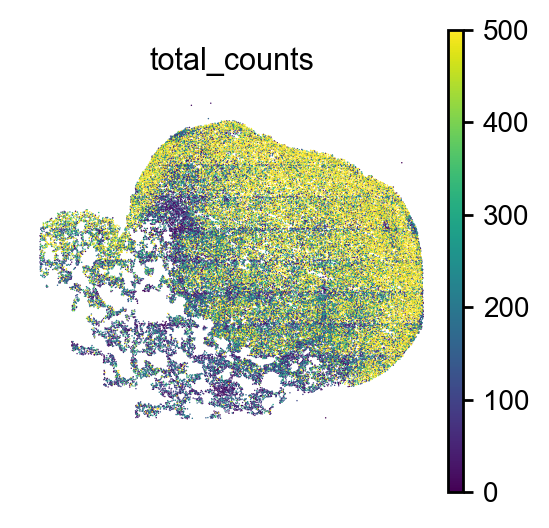

In [ ]:
sc.pp.calculate_qc_metrics(adata,percent_top=None, log1p=False, inplace=True)
sc.pl.spatial(adata,color = "total_counts",spot_size=10,frameon=False,vmax = 500)

Remove cells without enough transcripts or genes.

filtering 7151 cells out of 54532


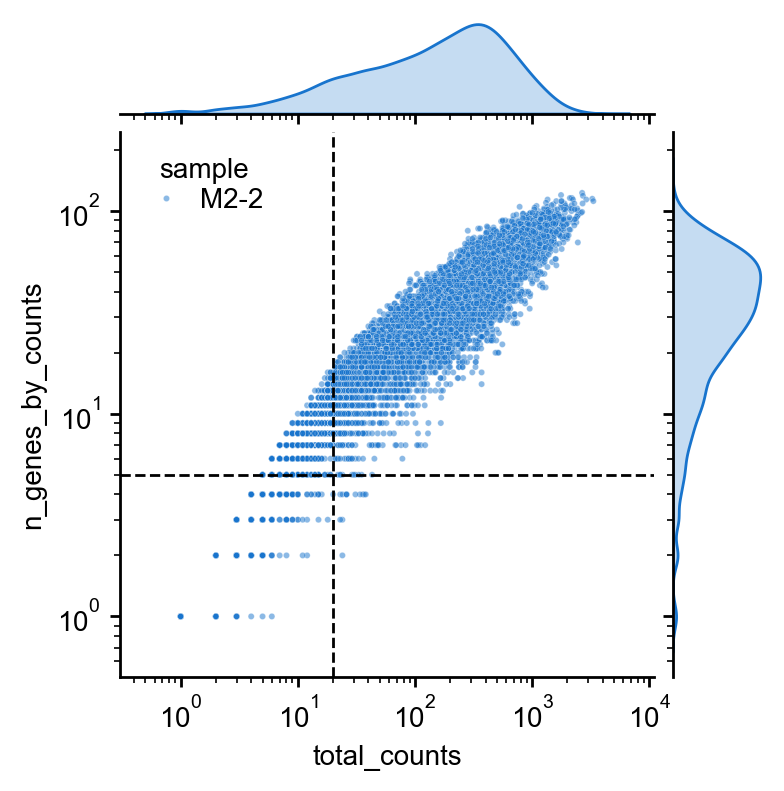

In [11]:
adata.obs["keep"] = True
adata.obs.loc[(adata.obs["total_counts"] < 1), "keep"] = False
min_genes = 5
min_counts = 20
sns.jointplot(data=adata.obs.query("keep").sample(10000),x="total_counts",y="n_genes_by_counts",kind="scatter",s=5, alpha=0.5,marginal_kws=dict(log_scale=True),height=4, hue="sample")
plt.axhline(min_genes, color='black', linestyle='dashed', linewidth=1)
plt.axvline(min_counts, color='black', linestyle='dashed', linewidth=1)
adata.obs.loc[(adata.obs["n_genes_by_counts"] < min_genes) | (adata.obs["total_counts"] < min_counts), "keep"] = False
print("filtering", len(adata.obs[~adata.obs["keep"]]), "cells", "out of", len(adata.obs))

/tmp/ipykernel_52416/4120225999.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  adata.obs.groupby(["sample","keep"]).size().unstack().fillna(0).plot(kind="bar", stacked=True)


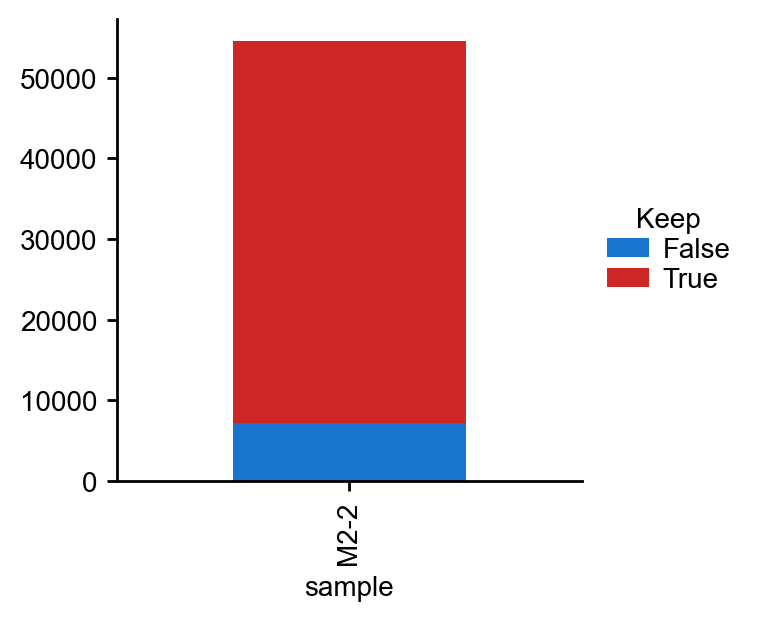

In [ ]:
adata.obs.groupby(["sample","keep"]).size().unstack().fillna(0).plot(kind="bar", stacked=True)
adata = adata[adata.obs["keep"]].copy()
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), title="Keep")

## Manual annotation

Generate UMAP

In [14]:
adata.layers["counts"] = sp.sparse.csr_matrix(adata.X.copy())
adata.X = adata.layers['counts'].copy()
sc.pp.normalize_total(adata, target_sum=2e2)
sc.pp.log1p(adata)
adata.layers["normalized"] = adata.X.copy()
sc.pp.regress_out(adata, ["total_counts"])
sc.pp.scale(adata)
sc.pp.pca(adata, n_comps=20)
sc.pp.neighbors(adata)
adata.layers["scaled"] = adata.X.copy()
sc.tl.umap(adata,random_state=0,min_dist = 0.25,spread=1)

Transcripts per cell

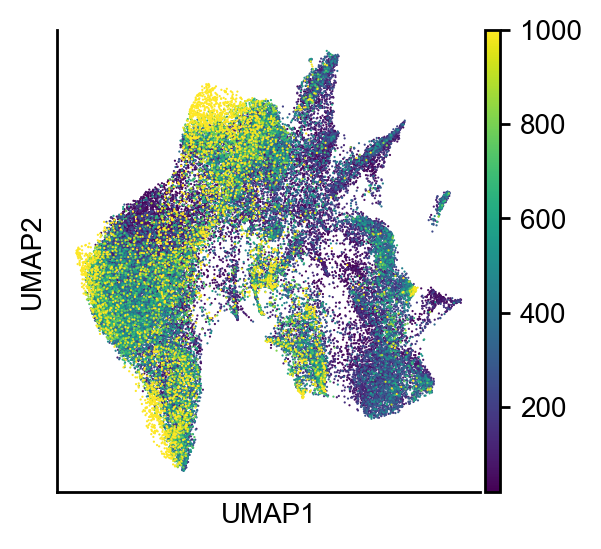

In [15]:
sc.pl.umap(adata,color = "total_counts",title="",vmax = 1000)

Marker genes

In [ ]:
sc.pl.umap(adata, color=["Wnt7b", "Col5a2", "Cd3g", "Shank3", "C1qb", 
                         "Itgax", "Cd22", "Chil1", "Arg1","Batf3","Cyp4b1",'Ncr1',
                         "Cxcr2", "Foxp3", "Cd8a", "Cd4", "Alox15", "Galnt18"
                         , "Itgb6", "Lamp3", "Car4", "Krt79", "Aplnr"
                         , "Wnt2", "Prex2", "Abca8a", "Havcr2", "Shank3"], use_raw=False, ncols = 4,show=False);

Course clustering

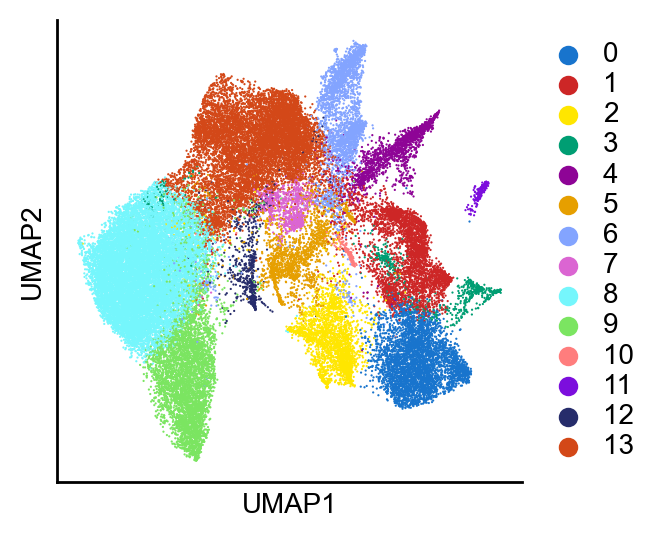

In [17]:
sc.tl.leiden(adata,resolution=.6,key_added="leiden",
             flavor = "igraph",n_iterations = 2,random_state = 0)
sc.pl.umap(adata,color = "leiden",title="")

Fine clustering

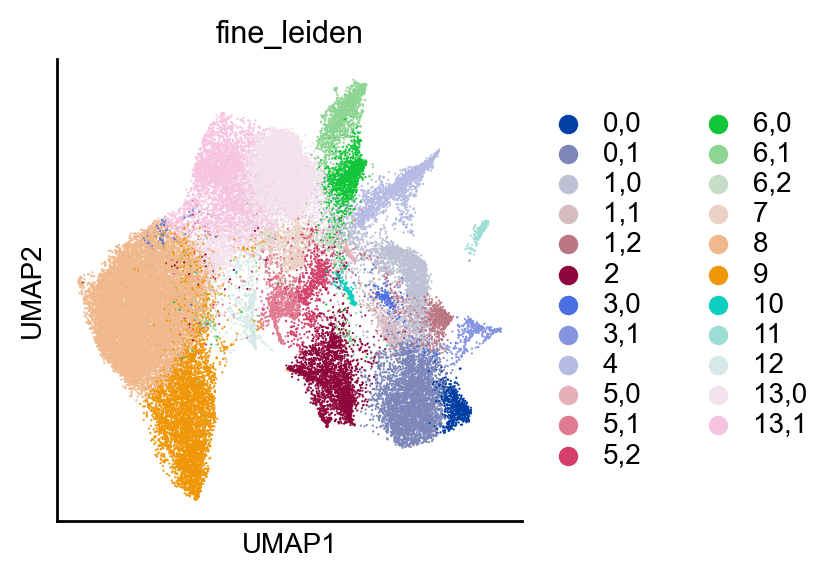

In [18]:
clusters = {"0": 0.2, "1" : 0.15,"3":0.1, "5": 0.2, "6": 0.3, "13": 0.2
           }
adata.obs["fine_leiden"] = adata.obs["leiden"]
for cluster, resolution in clusters.items():
    sc.tl.leiden(adata,resolution=resolution,restrict_to=("fine_leiden",[cluster]),key_added="fine_leiden",
                 flavor = "igraph",n_iterations = -1,random_state = 0)
sc.pl.umap(adata,color = "fine_leiden")

Annotate clusters using marker genes

In [ ]:
cell_type_markers = {"B cell": ["Cd22", "Cd79a"]
                     , "NK" : ["Ncr1", "Klrk1"]
                     , "CD11c macrophage": ["Itgax", "C1qb", "Mrc1"]
                     , "ARG1 macrophage": ["Arg1", "C1qb", "Dab2"]
                     , "AT1/AT2" : ["Lamp3", "Chil1", "Itgb6"]
                     , "cDC": ["Batf3", "Xcr1", "Flt3"]
                     , "Malignant": ["Wnt7b", "Nes"]
                     , "Malignant cycling": ["Wnt7b", "Itgb4", "Cdca2", "Kif2c"]
                     , "CAP1 endothelial": ["Shank3", "Aplnr"]
                     , "CAP2 endothelial": ["Shank3", "Car4", "Pllp"]
                     , "Tumor endothelial": ["Shank3",  "Robo4", "Fscn1"]
                     , "Alveolar fibroblast 1":["Col5a2", "Wnt2", "Cxcl14"]
                     , "Alveolar fibroblast 2":["Col5a2", "Abca8a", "Ebf1"]
                     , "Cancer fibroblast": ["Col5a2", "Dab2"]
                     , "Club cell": ["Cyp4b1", "Galnt18"]
                     , "pDC": ["Siglech", "Ccr9"]
                     , "Exhausted CD8 T cell": ["Cd3g", "Cd28", "Ifng", "Havcr2", "Cd8a"]
                     , "Treg": ["Cd3g", "Cd28","Cd4","Foxp3"]
                     , "Neutrophil": ["Cxcr2", "Asprv1"]
                     , "Alveolar macrophage": ["F7", "Car4", "Krt79"]
                    }
all_markers = [x for xs in list(cell_type_markers.values()) for x in xs] 

genesets = {}
for i in cell_type_markers.keys(): 
    genesets[i] = {"positive": cell_type_markers[i]
                   , "negative": np.setdiff1d(all_markers,cell_type_markers[i]).tolist()
                  }
masks = {}

for i in list(genesets.keys()): 
    masks[i] = get_cell_mask(adata, genesets[i], 200)

seed_labels = pd.Series(masks[list(masks.keys())[0]].shape[0] * ["unknown"])
for i in masks.keys():
    seed_labels[masks[i]] = i

In [ ]:
adata.obs["seed_labels"] = np.array(seed_labels)
df = adata.obs[adata.obs.seed_labels != 'unknown'].groupby(by=["seed_labels", "fine_leiden"]
                                                           , observed=True).size().reset_index(name='count')
df = df.sort_values(['seed_labels', 'count'], ascending=False).groupby('seed_labels').head(1)
mapping_dict = df.set_index('fine_leiden')['seed_labels'].to_dict()
adata.obs['cell_subtype'] = adata.obs['fine_leiden'].map(mapping_dict).astype('category')
adata.obs['cell_subtype'] = adata.obs['cell_subtype'].cat.add_categories("unknown")
adata.obs['cell_subtype'] = adata.obs['cell_subtype'].replace({"Malignant cycling":"Malignant"})

Annotations

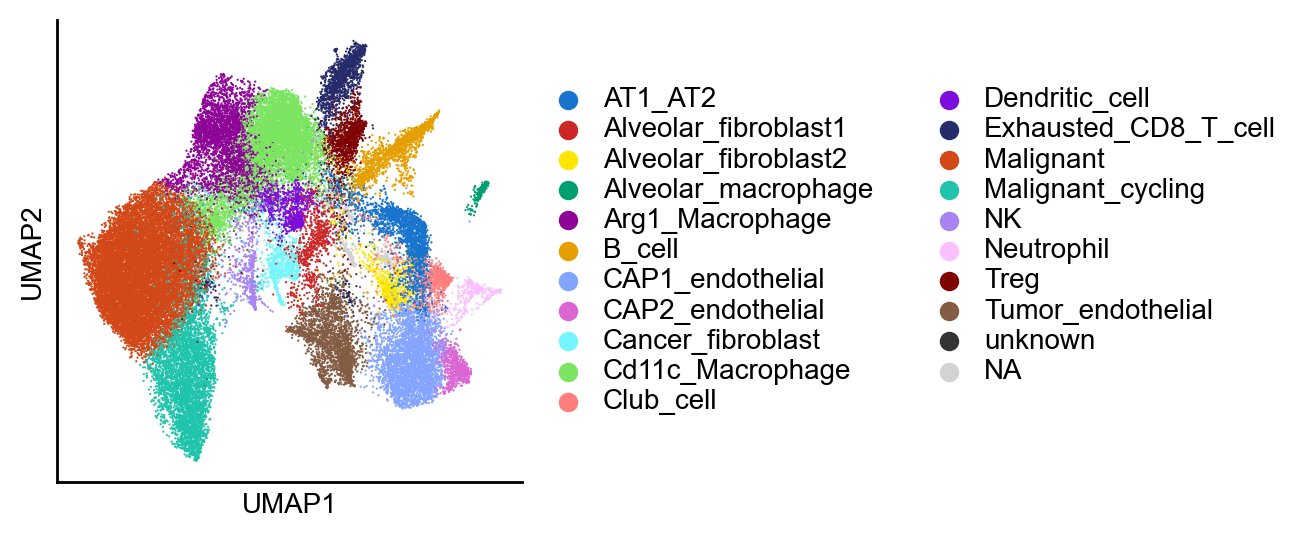

In [21]:
sc.pl.umap(adata,color = "cell_subtype",title="")

## Train resolVI

In [22]:
adata.obsm["X_spatial"] = adata.obsm["spatial"]
adata_train = adata[adata.obs.cell_subtype.notna()].copy()
adata_train.obs_names = [f'train_{i}' for i in adata_train.obs_names]

In [23]:
scvi.external.RESOLVI.setup_anndata(adata_train, labels_key="cell_subtype", layer='counts', batch_key="sample")
resolvi = scvi.external.RESOLVI(adata_train, semisupervised=True, downsample_counts = False)

/lab/solexa_weissman/kyost/miniconda3/envs/fishtank2/lib/python3.11/abc.py:119: FutureWarning: SparseDataset is deprecated and will be removed in late 2024. It has been replaced by the public classes CSRDataset and CSCDataset.

For instance checks, use `isinstance(X, (anndata.experimental.CSRDataset, anndata.experimental.CSCDataset))` instead.

For creation, use `anndata.experimental.sparse_dataset(X)` instead.

  return _abc_instancecheck(cls, instance)
An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.


INFO     Generating sequential column names                                                                        
INFO     Generating sequential column names                                                                        


/lab/solexa_weissman/kyost/miniconda3/envs/fishtank2/lib/python3.11/site-packages/scvi/data/fields/_dataframe_field.py:190: UserWarning: Category 0 in adata.obs['_scvi_ind_x'] has fewer than 3 cells. Models may not train properly.
  categorical_mapping = _make_column_categorical(


In [24]:
resolvi.train(max_epochs=100)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/lab/solexa_weissman/kyost/miniconda3/envs/fishtank2/lib/python3.11/site-packages/lightning/pytorch/trainer/configuration_validator.py:69: UserWarning: You passed in a `val_dataloader` but have no `validation_step`. Skipping val loop.
  rank_zero_warn("You passed in a `val_dataloader` but have no `validation_step`. Skipping val loop.")
You are using a CUDA device ('NVIDIA RTX A6000') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
SLURM auto-requeueing enabled. Setting signal handlers.
/lab/solexa_weissman/kyost/miniconda3/envs/fishtank2/li

Epoch 100/100: 100%|████████████████████████████████████████████████████████| 100/100 [21:44<00:00, 13.71s/it, v_num=1, elbo_train=3.71e+7]

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 100/100: 100%|████████████████████████████████████████████████████████| 100/100 [21:44<00:00, 13.04s/it, v_num=1, elbo_train=3.71e+7]


In [25]:
adata_train.obsm["resolvi_celltypes"] = resolvi.predict(adata_train, num_samples=3, soft=True)

INFO     AnnData object appears to be a copy. Attempting to transfer setup.                                        


/lab/solexa_weissman/kyost/miniconda3/envs/fishtank2/lib/python3.11/site-packages/scvi/data/_utils.py:240: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[_constants._SCVI_UUID_KEY] = str(uuid4())
/lab/solexa_weissman/kyost/miniconda3/envs/fishtank2/lib/python3.11/site-packages/scvi/data/fields/_dataframe_field.py:226: UserWarning: Category 0 in adata.obs['_scvi_ind_x'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(


Sampling variables, sample: 100%|██████████████████████████████████████████████████████████████████████████| 94/94 [00:56<00:00,  1.67it/s]


In [26]:
resolvi_celltypes = adata_train.obsm["resolvi_celltypes"]
adata_train.obs["resolvi_predicted"] = resolvi_celltypes[resolvi_celltypes > 0.5].idxmax(axis=1)
adata_train.obsm["X_resolVI"] = resolvi.get_latent_representation(adata_train)

/tmp/ipykernel_52416/2624540316.py:2: FutureWarning: The behavior of DataFrame.idxmax with all-NA values, or any-NA and skipna=False, is deprecated. In a future version this will raise ValueError
  adata_train.obs["resolvi_predicted"] = resolvi_celltypes[resolvi_celltypes > 0.5].idxmax(axis=1)


Generate resolVI UMAP

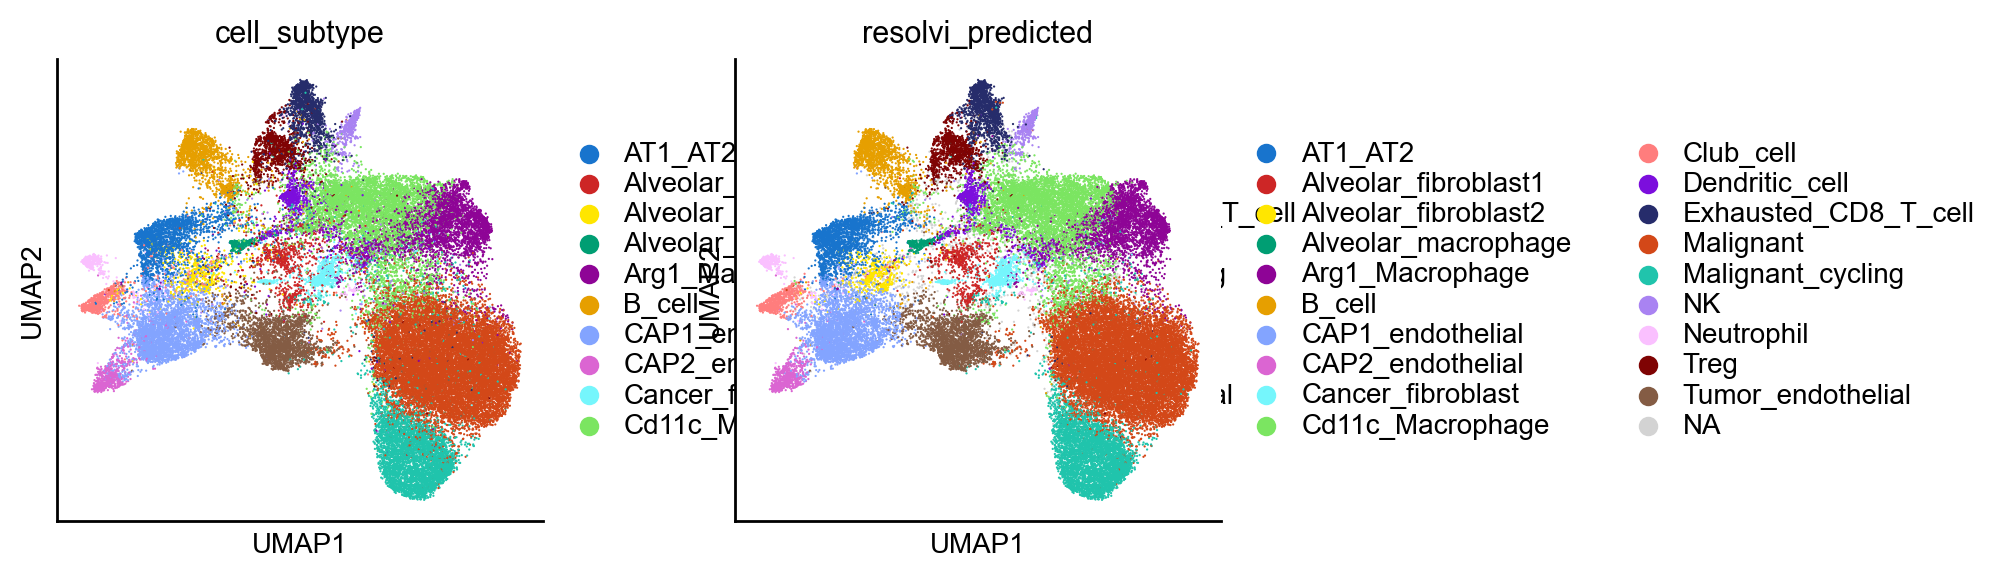

In [ ]:
sc.pp.neighbors(adata_train, use_rep="X_resolVI")
sc.tl.umap(adata_train,min_dist=.2)
sc.pl.umap(adata_train, color=['cell_subtype', 'resolvi_predicted'])

Calculate diffusion proportions

In [29]:
sample_mixtures = resolvi.sample_posterior_predictive(
    model=resolvi.module.model_residuals,
    return_sites=[
        'mixture_proportions'
        ],
    summary_fun={"post_sample_means": np.mean},
    num_samples=3, batch_steps=30)
sample_mixtures = pd.DataFrame(sample_mixtures).T

INFO     AnnData object appears to be a copy. Attempting to transfer setup.                                        


/lab/solexa_weissman/kyost/miniconda3/envs/fishtank2/lib/python3.11/site-packages/scvi/data/_utils.py:240: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[_constants._SCVI_UUID_KEY] = str(uuid4())
/lab/solexa_weissman/kyost/miniconda3/envs/fishtank2/lib/python3.11/site-packages/scvi/data/fields/_dataframe_field.py:226: UserWarning: Category 0 in adata.obs['_scvi_ind_x'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(


Sampling variables, sample: 100%|████████████████████████████████████████████████████████████████████████| 364/364 [01:57<00:00,  3.09it/s]


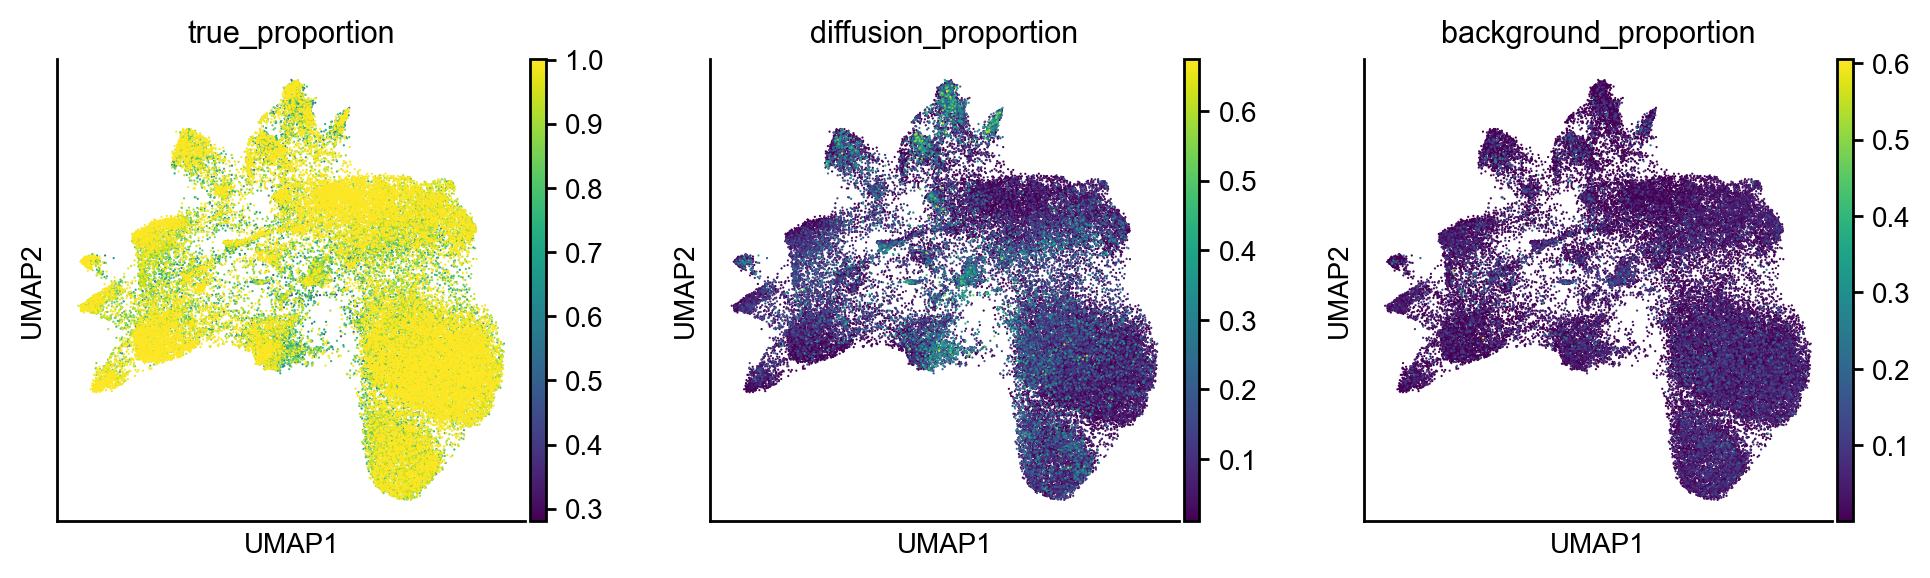

In [ ]:
adata_train.obs[['true_proportion', 'diffusion_proportion', 'background_proportion']] = sample_mixtures.loc['post_sample_post_sample_means', 'mixture_proportions']
sc.pl.umap(adata_train, color=[ 'true_proportion', 'diffusion_proportion', 'background_proportion'])

## Save model

In [ ]:
resolvi.save(data_path / "M3_resolVI")